In [38]:
import configparser
import os
import logging
import time

import hmac
import hashlib
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from requests import Response
from urllib.parse import urlencode
from typing import Optional, Dict, Any

In [2]:
class RESTClient:
    """Provide a Client for REST APIs."""
    
    def __init__(self, endpoint: str, path: str):
        self._endpoint = endpoint
        self._path = path

        
    def get_data(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        """Executes an HTTPS GET request."""
        
        try:
            response = requests.get(self._endpoint + self._path, params)
        except requests.exceptions.Timeout:
            logging.warning("Request has timed out")
        except requests.exceptions.ConnectionError:
            logging.warning("Request has faced a connection error")
            
        return self._process_response(response)

        
    def _process_response(self, response: Response) -> Any:
        """Processes the response the server sends to the clients request."""
        
        try:
            data = response.json()
        except ValueError:
            response.raise_for_status()
            raise
        else:
            return data

In [4]:
class BinanceFuturesClient(RESTClient):
    """Hold key information for Binance Spot Exchange."""

    def __init__(self):
        super().__init__('https://fapi.binance.com/', 'fapi/v1/klines')
        
        
class BinanceSpotClient(RESTClient):
    """Hold key information for Binance Spot Exchange."""

    def __init__(self):
        super().__init__('https://api.binance.com/', 'api/v3/klines')
    
    
class ByBitFuturesClient(RESTClient):
    """Hold key information for ByBit Futures Exchanges."""
    
    def __init__(self):
        super().__init__('https://api.bybit.com/', 'public/linear/kline')
        

class ByBitSpotClient(RESTClient):
    """Hold key information for ByBit Spot Exchange."""
    
    def __init__(self):
        super().__init__('https://api.bybit.com/', 'spot/v3/public/quote/kline')
    

class CoinglassClient(RESTClient):
    """Hold key information for Coinglass API."""
    
    def __init__(self):
        super().__init__('https://open-api.coinglass.com/', 'api/pro/v1/futures/openInterest')

In [12]:
class DataHandler:
    """Store price data and calculate and add other data such as OI, 
    funding, and CVD."""

    def __init__(self, vd: bool = False, funding: bool = False) -> None:
        self._vd = vd
        self._funding = funding
        
    
    def _compute_vd_helper(self, volume: float, taker_buy_volume: float) \
        -> float:
        """Computes the volume delta for a given candle."""
    
        vd = 2*taker_buy_volume - volume
        return vd


    def _compute_vd(self, quotes: pd.DataFrame) -> pd.DataFrame:
        """Computes the volume delta for a given dataframe."""
    
        quotes['volume_delta_base_asset'] = \
            quotes.apply(lambda x: self._compute_vd_helper( \
            x.volume, x.taker_buy_base_asset_volume), axis=1)
        quotes['volume_delta_quote_asset'] = \
            quotes.apply(lambda x: self._compute_vd_helper( \
            x.quote_asset_volume, x.taker_buy_quote_asset_volume), axis=1)

        return quotes

    
    def _compute_vd_ma(self, quotes: pd.DataFrame, window: int) -> pd.DataFrame:
        """Computes the volume delta moving average for a given dataframe."""
    
        quotes['volume_delta_moving_average_base_asset'] = \
            quotes['volume_delta_base_asset'].rolling(window=window).sum()
        quotes['volume_delta_moving_average_quote_asset'] = \
            quotes['volume_delta_quote_asset'].rolling(window=window).sum()

        return quotes

    
    def _compute_cvd(self, quotes: pd.DataFrame) -> pd.DataFrame:
        """Computes the cumulative volume delta for a given dataframe."""
    
        quotes['cvd_base_asset'] = quotes['volume_delta_base_asset'].cumsum()
        quotes['cvd_quote_asset'] = quotes['volume_delta_quote_asset'].cumsum()

        return quotes


    def fetch_historical_data(self, ec: RESTClient, market_name: str,
                                timeframe: str, start_time: datetime, 
                                end_time: datetime) -> pd.DataFrame:
        """Fetches historical data from the exchange via ExchangeClient."""

        response = ec.get_data('blabla', {'symbol' : market_name, 
            'interval' : timeframe, 'startTime' : str(int(start_time.timestamp()*1000)),
            'endTime' : str(int(end_time.timestamp()*1000)), 'limit' : '1000'})
   
        quotes = pd.DataFrame(response, columns = ['open time', 'open',
            'high', 'low', 'close', 'volume', 'close time',
            'quote_asset_volume', 'number of trades',
            'taker_buy_base_asset_volume', 
            'taker_buy_quote_asset_volume', 'unused field'])
        
        quotes[['open', 'high', 'low', 'close', 'volume', 
            'quote_asset_volume', 'taker_buy_base_asset_volume', 
            'taker_buy_quote_asset_volume']] \
            = quotes[['open', 'high', 'low', 'close', 'volume',
                'quote_asset_volume', 'taker_buy_base_asset_volume',
                'taker_buy_quote_asset_volume']].astype(float)

        if self._vd:
            quotes = self._compute_vd(quotes)

        funding = None
        if self._funding:
            response = ec.get_data(f'fapi/v1/fundingRate?symbol={self._market_name}'
                + f'&startTime={int((start_time-timedelta(days=1)).timestamp()*1000)}'
                + f'&endTime={int(end_time.timestamp()*1000)}')
            funding = pd.DataFrame(response, columns = \
                ['fundingTime', 'fundingRate'])
            funding['fundingRate'] = funding['fundingRate'].astype(float)

        return quotes, funding
        
        
    def fetch_current_data(self, ec: RESTClient, market_name: str,
                            timeframe: str) -> pd.DataFrame:
        """Fetches current data from the exchange via ExchangeClient."""
    
        response = ec.get_data('blabla', {'symbol' : market_name,
            'interval' : timeframe})

        quotes = pd.DataFrame(response, columns = ['open time', 'open',
            'high', 'low', 'close', 'volume', 'close time', 
            'quote_asset_volume', 'number of trades', 
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
            'unused field'])

        quotes[['open', 'high', 'low', 'close', 'volume',
            'quote_asset_volume', 'taker_buy_base_asset_volume',
            'taker_buy_quote_asset_volume']] \
            = quotes[['open', 'high', 'low', 'close', 'volume',
                'quote_asset_volume', 'taker_buy_base_asset_volume',
                'taker_buy_quote_asset_volume']].astype(float)

        quotes['datetime'] = pd.to_datetime(quotes['open time'], unit='ms')

        if self._vd:
            quotes = self._compute_vd(quotes)

        funding = None
        if self._funding:
            response = ec.get(f'fapi/v1/fundingRate?symbol={self._market_name}')
            funding = pd.DataFrame(response, 
                columns = ['fundingTime', 'fundingRate'])
            funding['fundingRate'] = funding['fundingRate'].astype(float)

        return quotes, funding

    
    def aggregate_data(self, ec: RESTClient, market_name: str, 
                       timeframe: str, start_time: datetime) -> pd.DataFrame:
        """Aggregates the data from several requests."""

        start_time = start_time
        end_time = start_time + timedelta(days=40)

        df = pd.DataFrame()
        
        while start_time < datetime.now():
    
            tmp_df, funding = self.fetch_historical_data(ec, market_name, timeframe, 
                                                     start_time, end_time)

            df = pd.concat([df, tmp_df], ignore_index=True)
    
            start_time = end_time
            end_time = end_time + timedelta(days=40)
        
        return df

In [28]:
client = BinanceSpotClient()
dh = DataHandler(vd=False, funding=False)

markets = [('BTCUSDT', 'spot'), ('ETHUSDT', 'spot'), ('BNBUSDT', 'spot'), ('SOLUSDT', 'spot'), 
           ('DOGEUSDT', 'spot')]

for market in markets:
    df = dh.aggregate_data(client, market[0], '1h', datetime(2017, 7, 14, 0, 0, 0, 0))
    df.to_csv(market[0] + '_1h_' + market[1] + '.csv')

In [30]:
for market in markets:

    df = pd.read_csv(market[0] + '_1h_' + market[1] + '.csv')
    dh = DataHandler(vd=False, funding=False)

    df = dh._compute_vd(df)
    df = dh._compute_vd_ma(df, 2400)
    df = dh._compute_cvd(df)

    df.to_csv(market[0] + '_1h_' + market[1] + '.csv')

In [67]:
def plot_vdma(df: pd.DataFrame, market_name: str) -> None:
    """Plot the cumulative volume delta accumulated over a rolling window."""

    fig, ax = plt.subplots(figsize=(18, 9))
    fig.suptitle(market_name)

    df['datetime'] = pd.to_datetime(df['open time'], unit='ms')

    ax.plot(np.array(df['datetime']), np.array(df['close']), color='red')
    ax2 = ax.twinx()
    ax2.plot(np.array(df['datetime']), np.array(df['volume_delta_moving_average_base_asset']))
    
    plt.show()

In [71]:
def plot_cvd(df: pd.DataFrame, market_name: str) -> None:
    """Plot the cumulative volume delta accumulated over the full history."""
    
    fig, ax = plt.subplots(figsize=(18, 9))
    fig.suptitle(market_name)
        
    df['datetime'] = pd.to_datetime(df['open time'], unit='ms')

    ax.plot(np.array(df['datetime']), np.array(df['close']), color='red')
    ax2 = ax.twinx()
    ax2.plot(np.array(df['datetime']), np.array(df['cvd_base_asset']))
    plt.show()

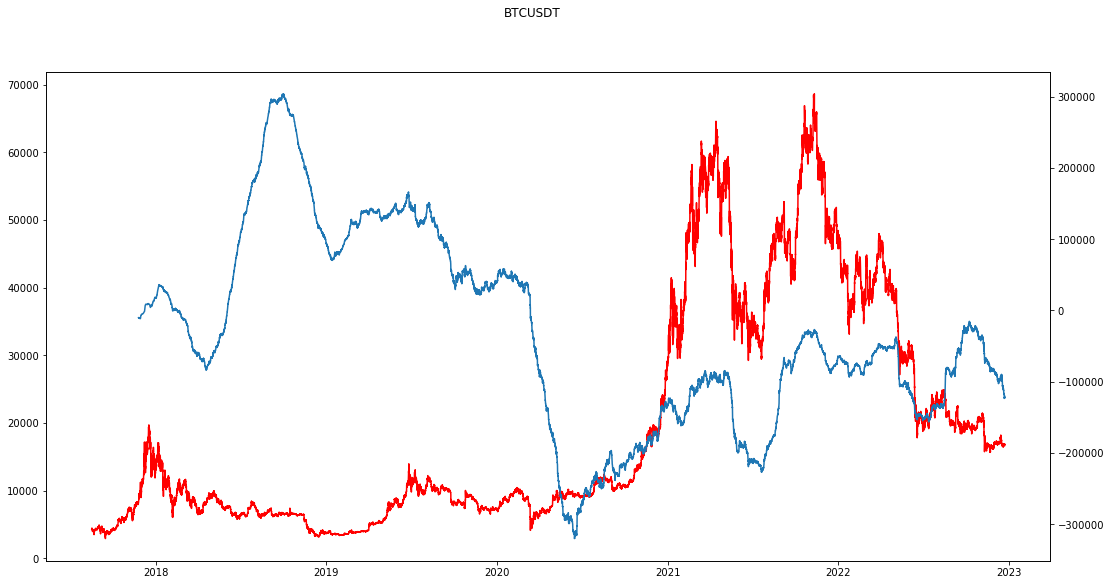

In [72]:
df_btc = pd.read_csv('BTCUSDT_1h_spot.csv')
plot_vdma(df_btc, 'BTCUSDT')

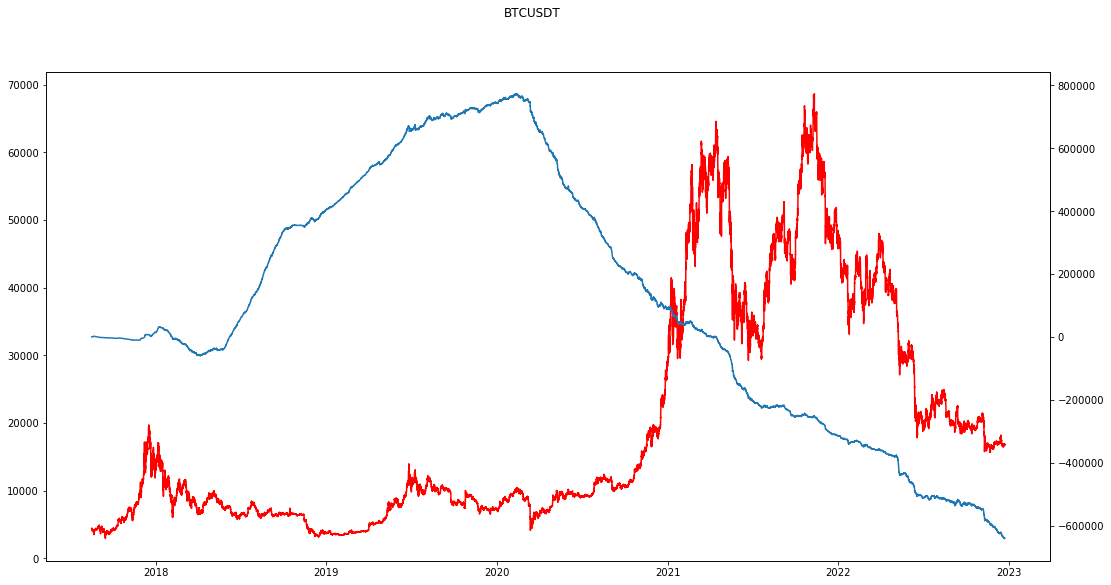

In [73]:
plot_cvd(df_btc, 'BTCUSDT')

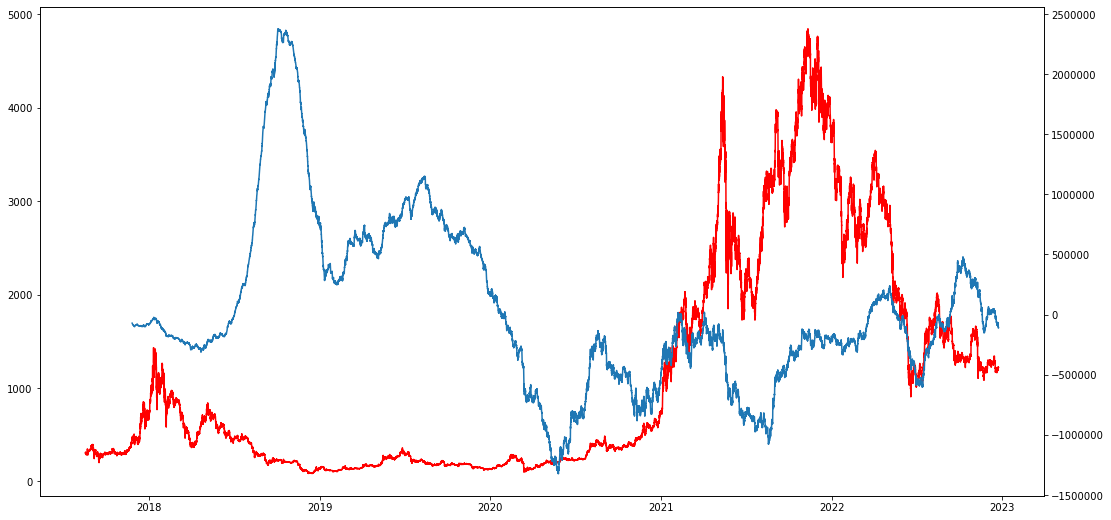

In [58]:
df_eth = pd.read_csv('./ETHUSDT_1h_spot.csv')
plot_vdma(df_eth, 'ETHUSDT')

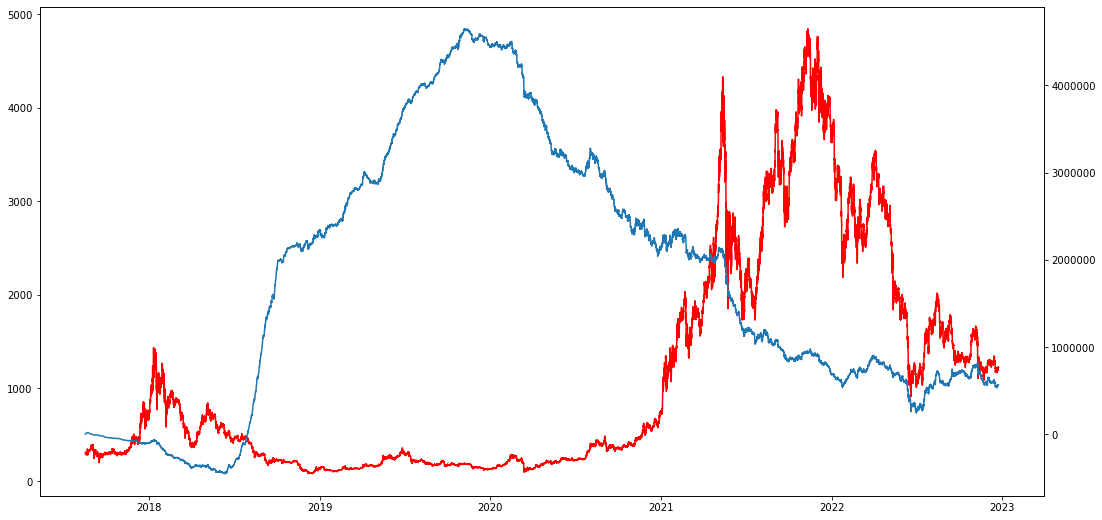

In [59]:
plot_cvd(df_eth, 'ETHUSDT')

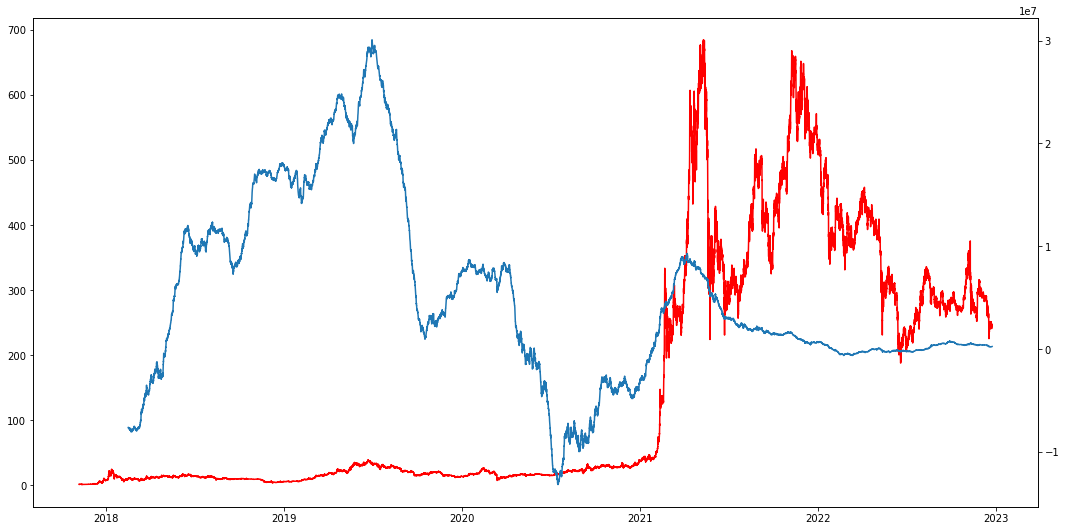

In [60]:
df_bnb = pd.read_csv('./BNBUSDT_1h_spot.csv')
plot_vdma(df_bnb, 'ETHUSDT')

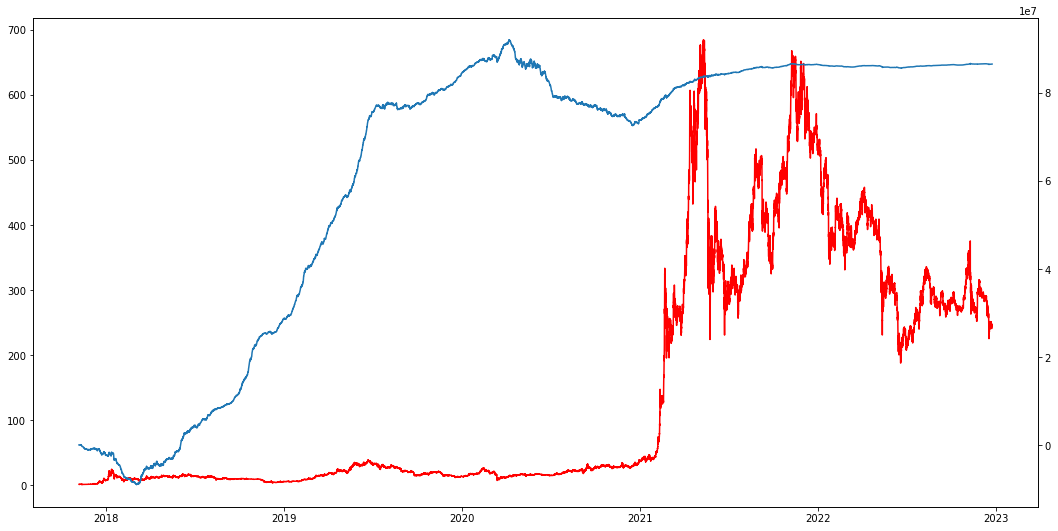

In [61]:
plot_cvd(df_bnb, 'ETHUSDT')

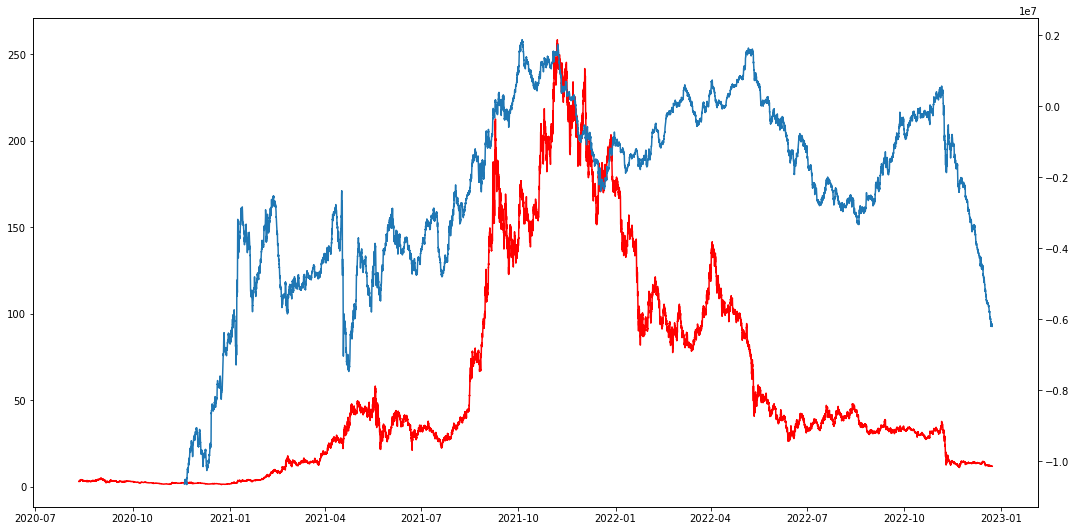

In [62]:
df_sol = pd.read_csv('./SOLUSDT_1h_spot.csv')
plot_vdma(df_sol, 'SOLUSDT')

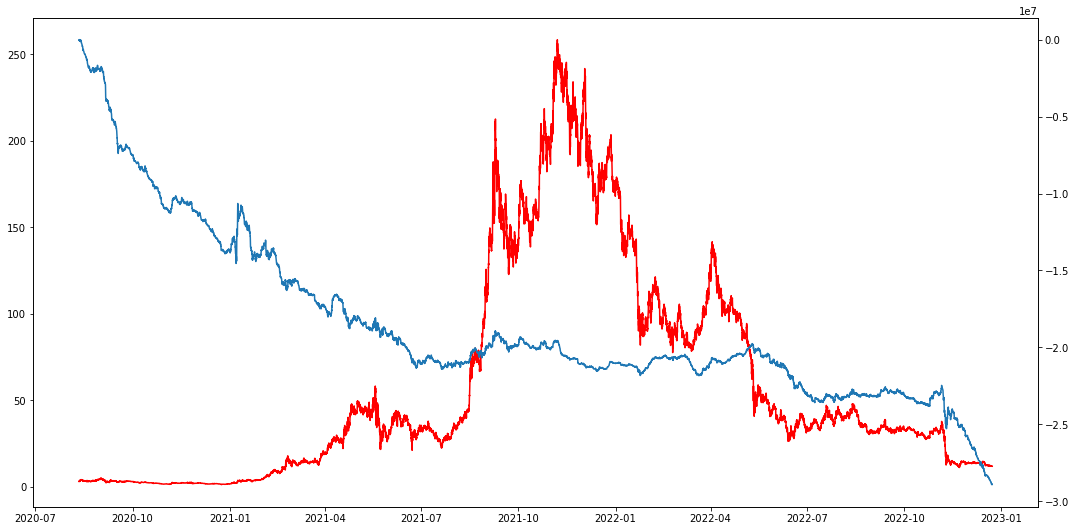

In [63]:
plot_cvd(df_sol, 'SOLUSDT')

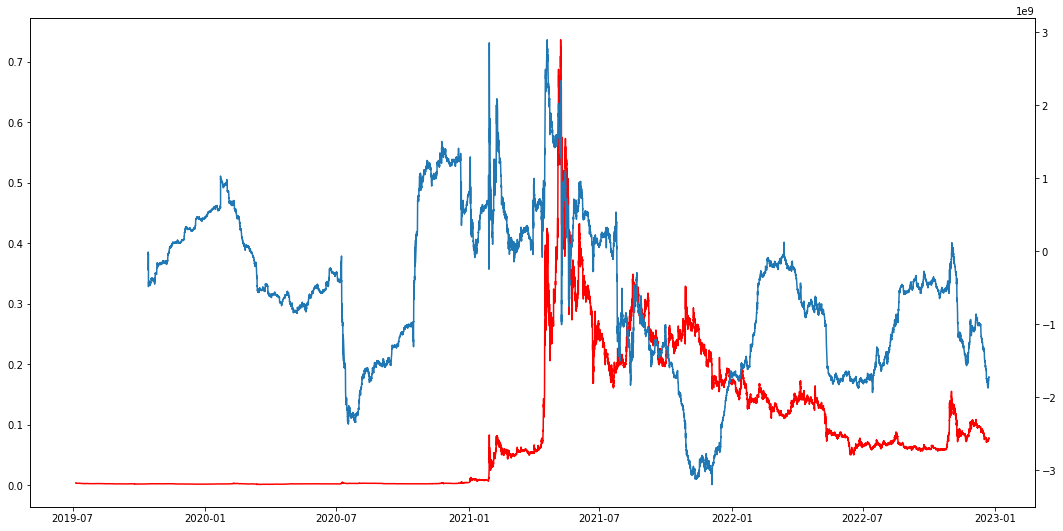

In [64]:
df_doge = pd.read_csv('./DOGEUSDT_1h_spot.csv')
plot_vdma(df_doge, 'DOGEUSDT')

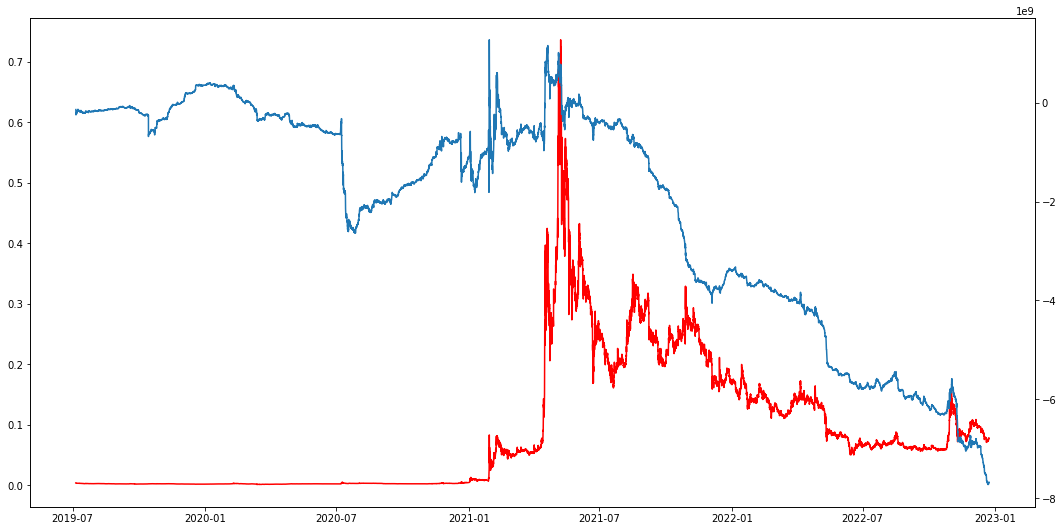

In [65]:
plot_cvd(df_doge, 'DOGEUSDT')